<a href="https://colab.research.google.com/github/savindumahasen/Chatbot/blob/main/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot with Lang-graph

In [80]:
!pip install langgraph langsmith
!pip install langchain langchain_groq langchain_community

In [81]:
## Use Groq and Lang smith API keys
from google.colab import userdata
groq_api_key=userdata.get('GROQ_API_KEY')
langsmith_api_key=userdata.get("LANG_SMITH_API_KEY")

In [82]:
## setup the  langsmith APi key
import os
os.environ["LANGCHAIN_API_KEY"]=langsmith_api_key
os.environ["LANCHAIN_TRACING_V2"]="true"
os.environ["LANCHAIN_PROJECT"]="chatbot"

In [83]:
from langchain_groq import ChatGroq
llm=ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7eb9081ad4d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7eb9098f9910>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

## Building the chatbot using Langgraph

In [84]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [85]:
!pip install arxiv wikipedia

In [86]:
## working with third party tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun


## Arxiv and Wikipedia tools

arxiv_wrapper=ArxivAPIWrapper(top_k_results=10, doc_content_chars_max=5000)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

wikipedia_wrapper=WikipediaAPIWrapper(top_k_results=10, doc_content_chars_max=5000)
wikipedia_tool=WikipediaQueryRun(api_wrapper=wikipedia_wrapper)

In [87]:
wikipedia_tool.invoke("Who is shiva")

"Page: Shiva\nSummary: Shiva (; Sanskrit: शिव, lit.\u2009'The Auspicious One', IAST: Śiva [ɕɪʋɐ]), also known as Mahadeva (; Sanskrit: महादेव:, lit.\u2009'The Great God', IAST: Mahādevaḥ, [mɐɦaːd̪eːʋɐh]) and Hara, is one of the principal deities of Hinduism. He is the Supreme Being in Shaivism, one of the major traditions within Hinduism.\nShiva is known as The Destroyer within the Trimurti, the Hindu trinity which also includes Brahma and Vishnu. In the Shaivite tradition, Shiva is the Supreme Lord who creates, protects and transforms the universe. In the goddess-oriented Shakta tradition, the Supreme Goddess (Devi) is regarded as the energy and creative power (Shakti) and the equal complementary partner of Shiva. Shiva is one of the five equivalent deities in Panchayatana puja of the Smarta tradition of Hinduism.\nShiva has many aspects, benevolent as well as fearsome. In benevolent aspects, he is depicted as an omniscient yogi who lives an ascetic life on Kailasa as well as a househ

In [88]:
arxiv_tool.invoke("Computer vision")

"Published: 2019-05-20\nTitle: Implications of Computer Vision Driven Assistive Technologies Towards Individuals with Visual Impairment\nAuthors: Linda Wang, Alexander Wong\nSummary: Computer vision based technology is becoming ubiquitous in society. One\napplication area that has seen an increase in computer vision is assistive\ntechnologies, specifically for those with visual impairment. Research has shown\nthe ability of computer vision models to achieve tasks such provide scene\ncaptions, detect objects and recognize faces. Although assisting individuals\nwith visual impairment with these tasks increases their independence and\nautonomy, concerns over bias, privacy and potential usefulness arise. This\npaper addresses the positive and negative implications computer vision based\nassistive technologies have on individuals with visual impairment, as well as\nconsiderations for computer vision researchers and developers in order to\nmitigate the amount of negative implications.\n\nPub

In [89]:
tools=[wikipedia_tool,arxiv_tool]

In [90]:
## Build the graph

class State(TypedDict):
  ## Messages have type "list". The add_messages function
  ## In the annotation defines how  this state key should be updated
  ## in this case, append messages to the list rather than overwriting it
  messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)


In [91]:
graph_builder

In [92]:
## bind the tools with llm

llm_with_tools=llm.bind_tools(tools=tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7eb9081ad4d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7eb9098f9910>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'wikipedia', 'description': 'A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'query to look up on wikipedia', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'arxiv', 'description': 'A wrapper around Arxiv.org Useful for when you need to answer questions about Physics, Mathematics, Computer Science, Quantitative Biology, Quantitative Finance, Statistics, Electrical Engineering, and Economics from

In [93]:
def chatbot(state:State):
  return {"messages":llm_with_tools.invoke(state['messages'])}

In [94]:
graph_builder.add_node("chatbot", chatbot)
graph_builder

In [95]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot",END)

In [96]:
## intergrate tools with  chatbot
from langgraph.prebuilt import ToolNode, tools_condition
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)


graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge("chatbot",END)

In [97]:
## compile the graph builder
graph=graph_builder.compile()

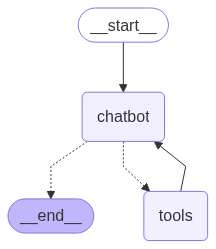

In [98]:
## display the graph

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(graph.get_graph().draw_mermaid_png()))

In [99]:
## Test the bot with some user queries

In [ ]:
while True:
  user_input=input("User ")
  if user_input.lower() in ["quit","buy"]:
    print("Good Buy")
    break
  for event in graph.stream({'messages':("user",user_input)}):
    #print(event.values())
    for value in event.values():
      #print(value['messages'])
      print("Assistant:",value['messages'].content)